In [1]:
# import os
# os.environ["PYOPENGL_PLATFORM"] = "egl"

%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import open3d as o3d
import pathlib

from CARTO.Decoder import config, utils
from CARTO.Decoder.visualizing import code_vis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


CRITICAL:root:No module named 'asdf'
Traceback (most recent call last):
  File "/home/nickheppert/projects/CARTO/CARTO/Decoder/data/asdf_dataset.py", line 19, in <module>
    from asdf.data import SDFSamples
ModuleNotFoundError: No module named 'asdf'


In [3]:
torch.cuda.set_device(1)

# Loading the Model

In [4]:
DECODER_TRAINING_ID = "506fd5f4-ff54-4413-8e13-6f066f182dfb"
local_dir = config.BASE_DIR / "runs" / DECODER_TRAINING_ID
vis_dir = local_dir / "vis" / "interpolation"
vis_dir.mkdir(exist_ok=True, parents=True)

In [5]:
print(f"Loading from {local_dir = }")
(
    decoder,
    joint_state_decoder,
    shape_embedding,
    joint_embedding,
    additional_outputs,
) = utils.load_full_decoder(
    DECODER_TRAINING_ID,
    additional_outputs={"cfg": None},
)

Loading from local_dir = PosixPath('/home/nickheppert/projects/CARTO/CARTO/Decoder/../../datasets/decoder/runs/506fd5f4-ff54-4413-8e13-6f066f182dfb')
DatasetChoice.ours
S = array([6.5686107 , 4.1675878 , 3.8382232 , 3.362702  , 2.863437  ,
       2.6507514 , 2.2964356 , 2.2625654 , 2.0919855 , 2.0237129 ,
       1.921594  , 1.8096942 , 1.7642995 , 1.6535197 , 1.6381592 ,
       1.5763203 , 1.5650297 , 1.466106  , 1.4363924 , 1.3881068 ,
       1.3439969 , 1.2861332 , 1.2686845 , 1.2028935 , 1.1674927 ,
       1.1340964 , 1.0672671 , 0.99428385, 0.97762   , 0.90279317,
       0.8203493 , 0.77917427], dtype=float32)


S = array([118.53704   ,   9.291283  ,   2.801921  ,   2.1654294 ,
         1.0963266 ,   0.8572624 ,   0.71265227,   0.5916847 ,
         0.53369105,   0.4970821 ,   0.47672355,   0.44273704,
         0.42907718,   0.4191601 ,   0.39452162,   0.36457324],
      dtype=float32)
Decoder(
  (lin0): Linear(in_features=48, out_features=509, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=496, bias=True)
  (lin3): Linear(in_features=512, out_features=509, bias=True)
  (lin4): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (th): Tanh()
)


# Visualize Embeddings

Scatter for ShapeEmbedding


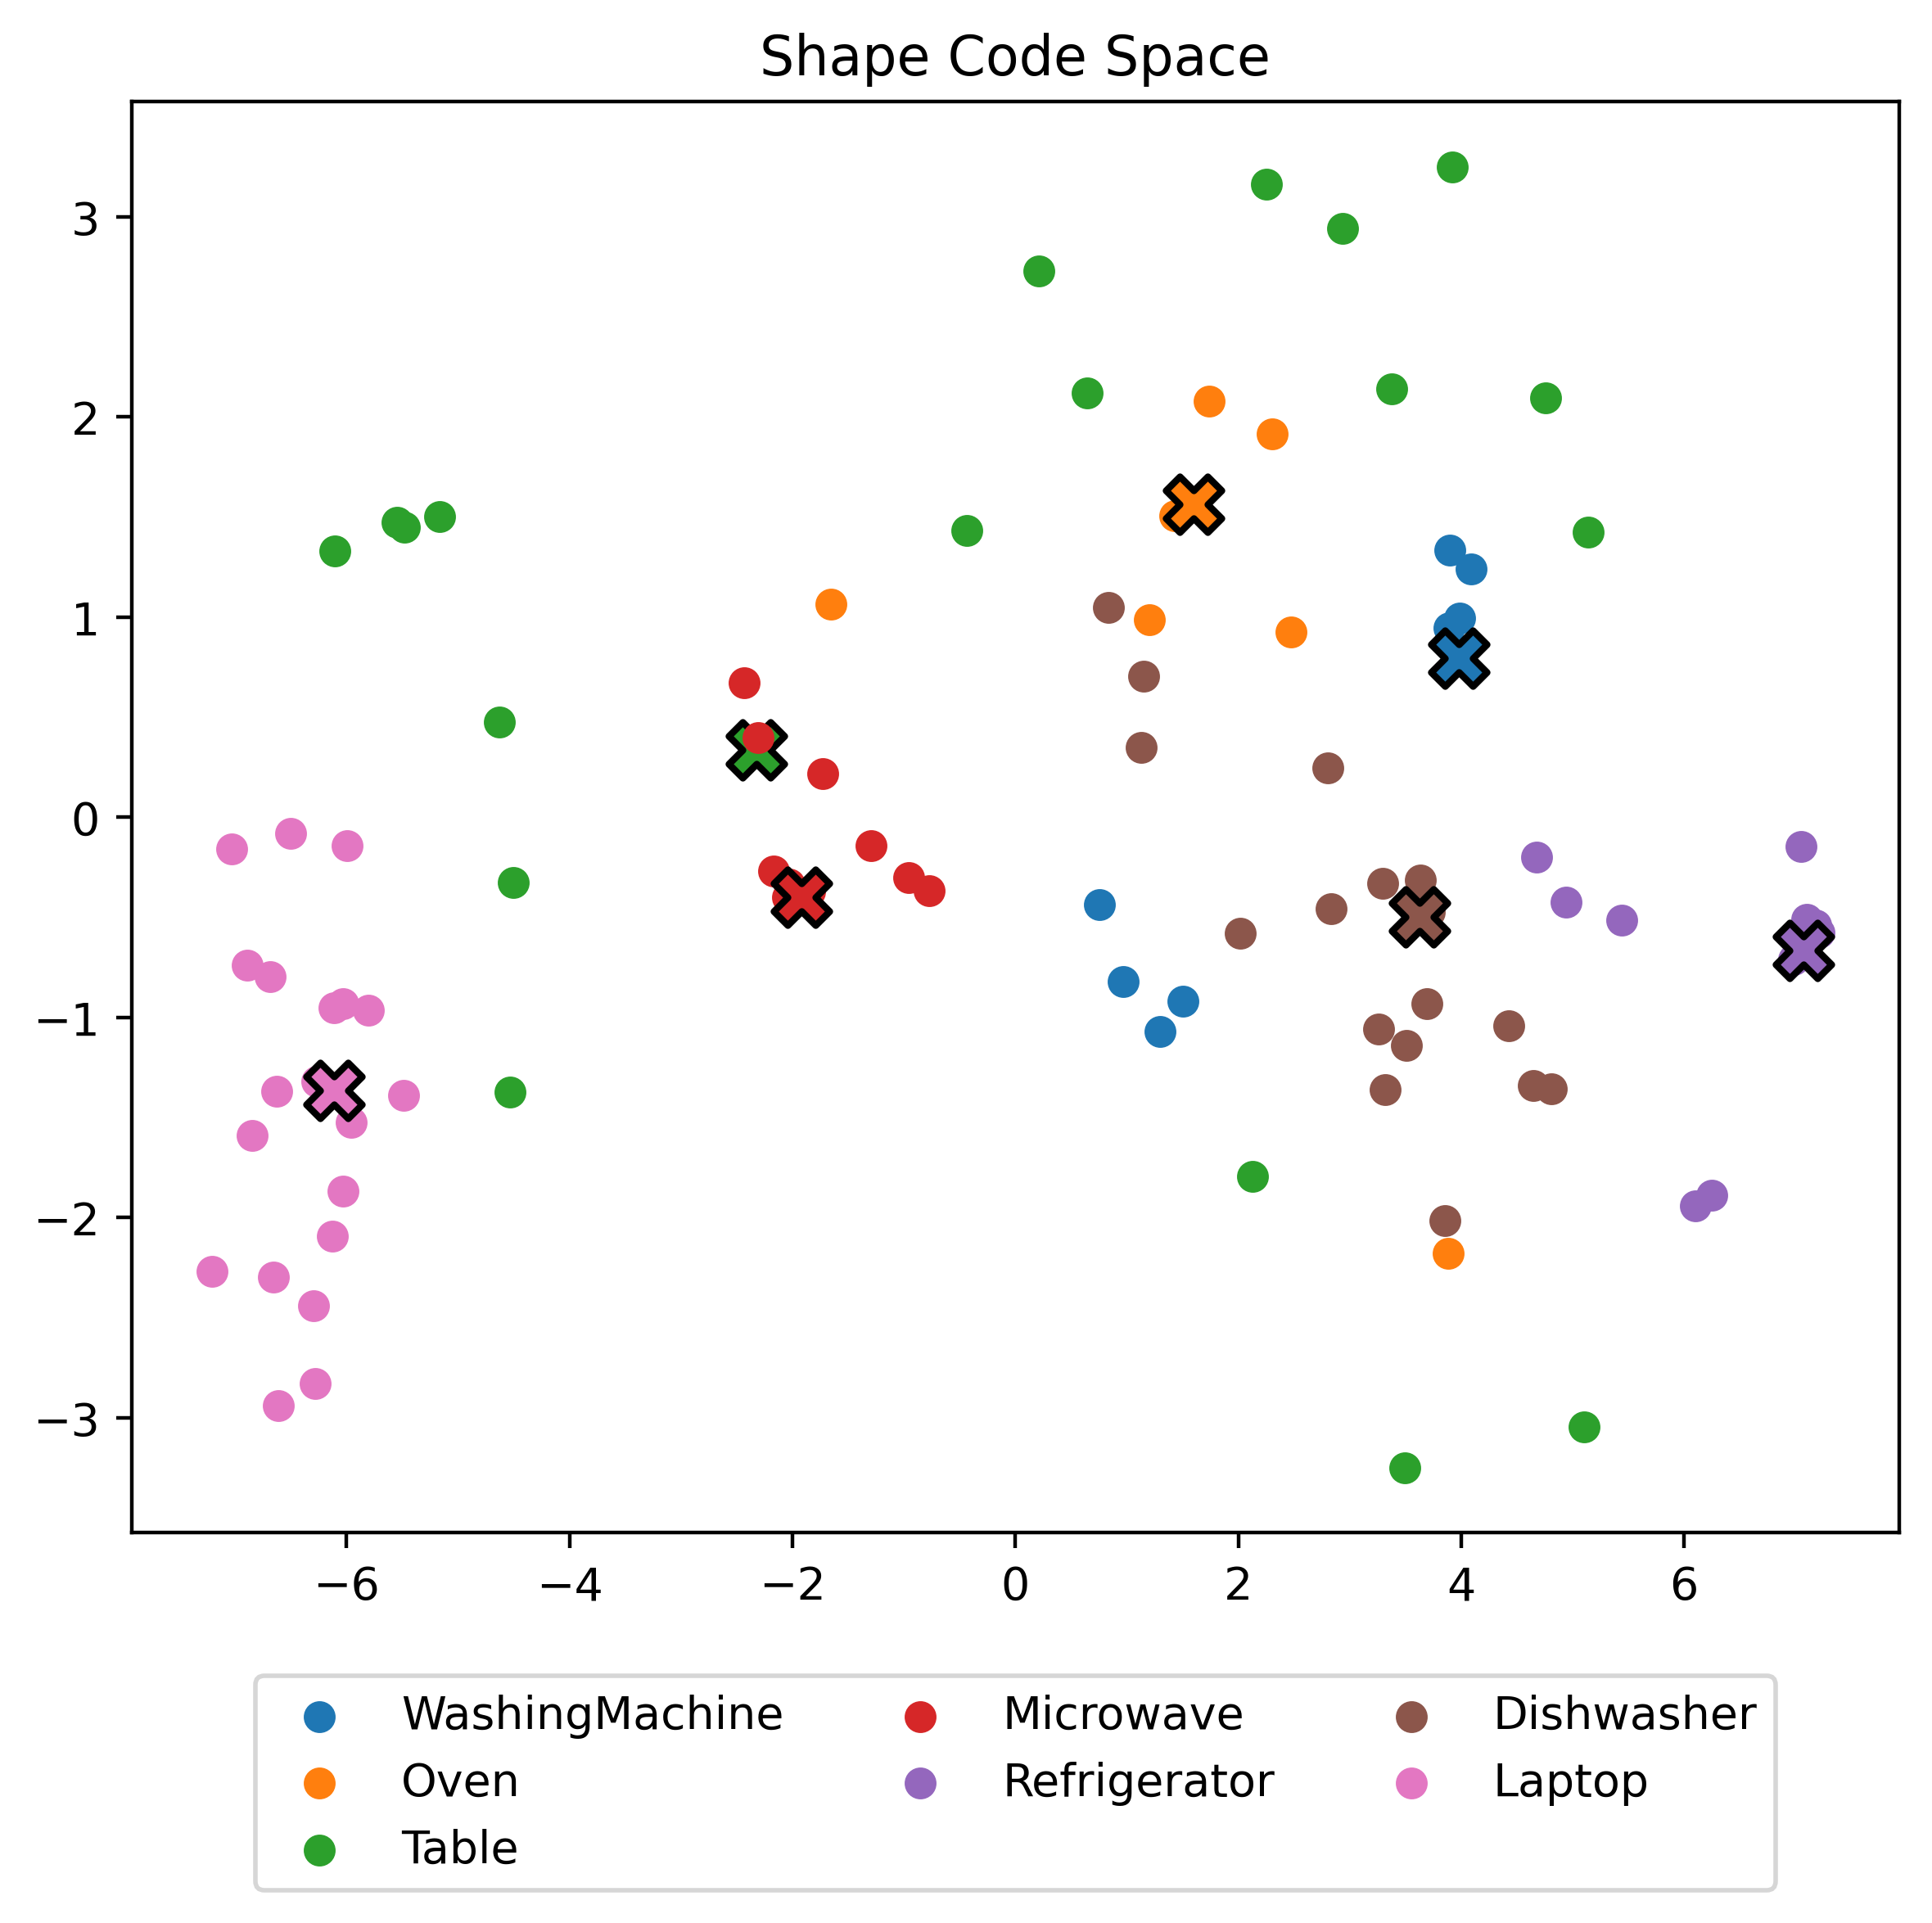

In [6]:
fig, ax = plt.subplots(dpi=400, figsize=(6, 6))
shape_embedding.get_scatter(ax, do_tsne=True, mark_means=True)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), borderaxespad=0, ncol=3)
fig.tight_layout()
fig.savefig(str(vis_dir / "shape_tsne_embedding.pdf"))

Plot each dimensions

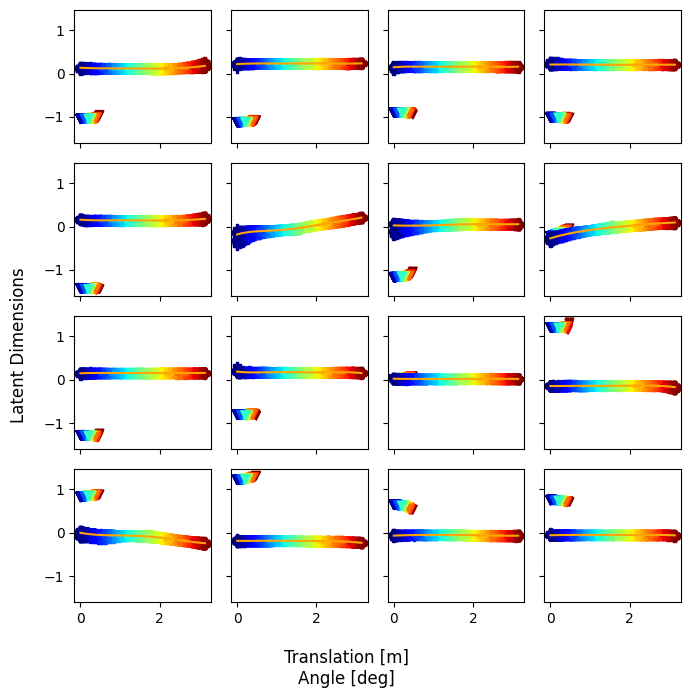

In [7]:
point_clusters = joint_embedding.get_joint_type_clusters()
# Whether to highlight the revolute or prismatic codes
joint_type = "revolute"
# joint_type = "prismatic"

types, values = utils.extract_type_and_value(
    joint_embedding.joint_definitions, joint_embedding.joint_config_dicts
)
values = np.array(values)

values_joint = values[np.array(types) == joint_type]
embedding_vecs = joint_embedding.embedding_matrix.numpy()
multi_poly = joint_embedding.poly_fits[joint_type]
fig, axes = multi_poly.get_plot(values, embedding_vecs, types=types)

fig.supxlabel("Translation [m]\nAngle [deg]")
fig.supylabel("Latent Dimensions")
fig.tight_layout()
fig.savefig(str(vis_dir / "articulation_all_dims.pdf"))

Plot low-dimensional projection

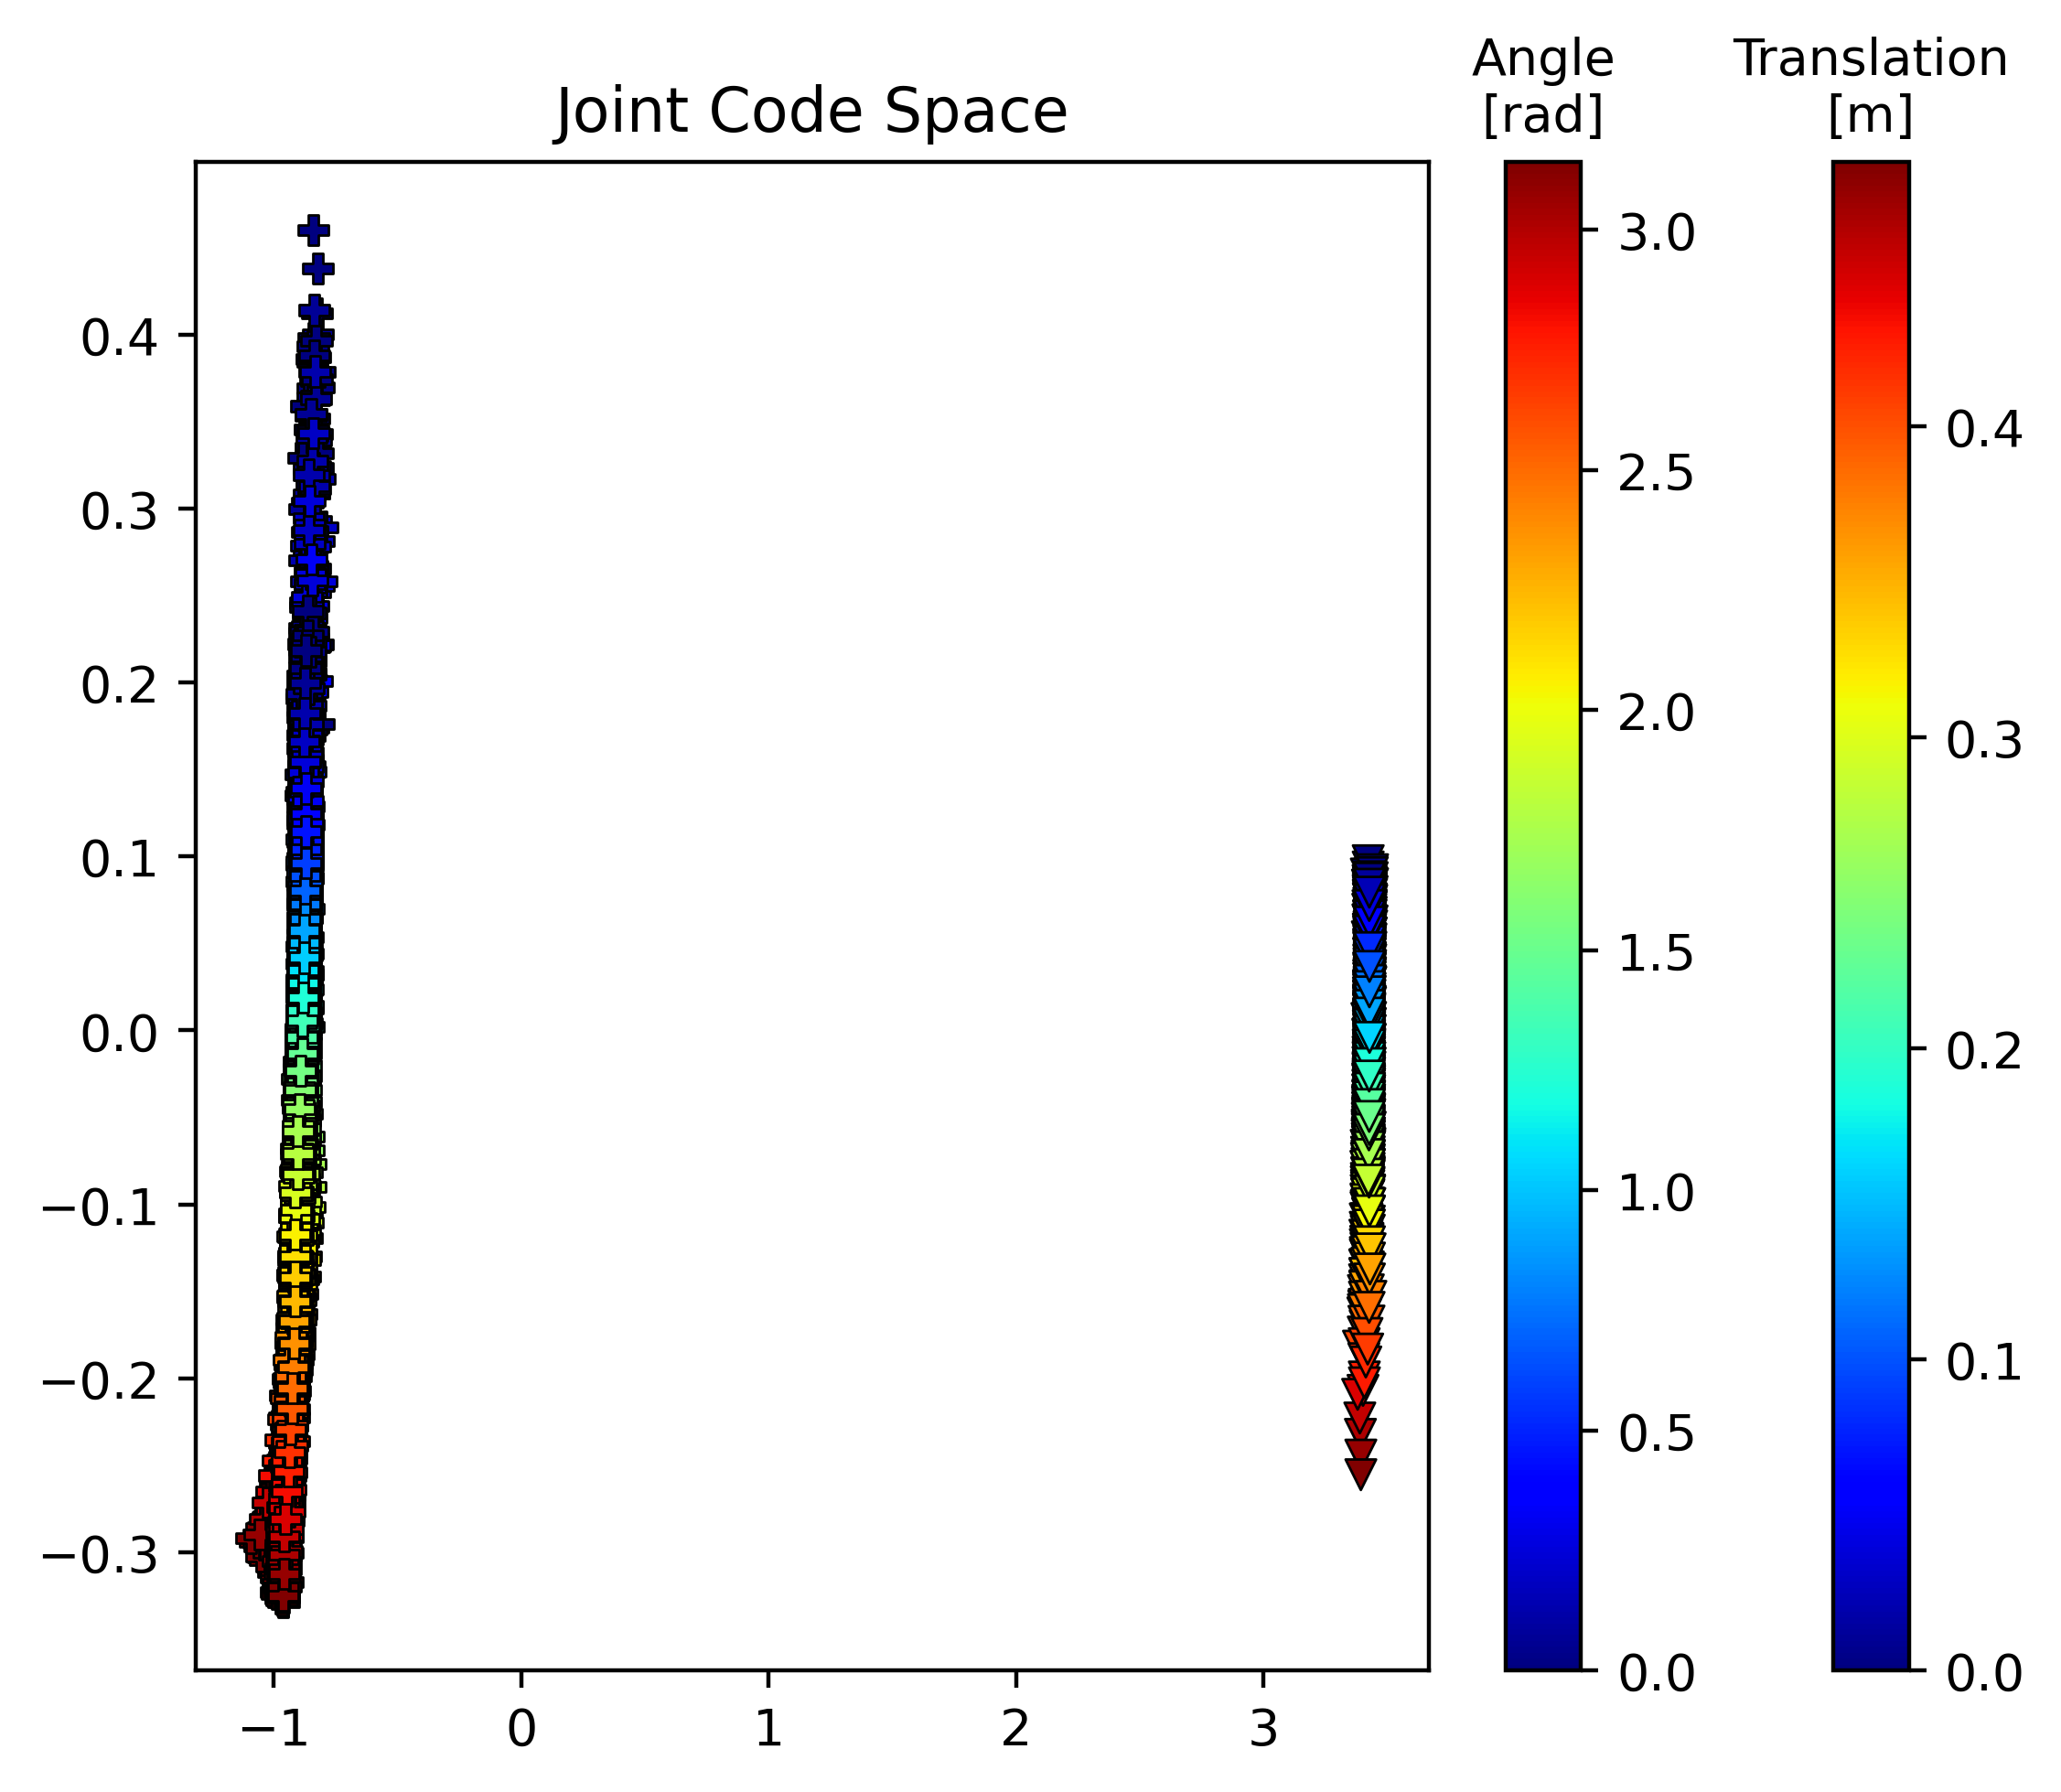

In [8]:
fig, ax = plt.subplots(dpi=400, figsize=(6, 5))
joint_embedding.get_scatter(
    ax,
)
fig.tight_layout()
fig.savefig(str(vis_dir / "articulation_two_dim.pdf"))

# Reconstruct Object Instance

In [9]:
# Specific Object ID
# object_id = "36d62d9dcba0e3ec4da5feafe6f1c8fc"
# shape_code = shape_embedding.get_shape_code(object_id)

# Category Mean
category = "Laptop"
categoy_shape_means = shape_embedding.get_category_means()
shape_code = categoy_shape_means[category]

In [10]:
# Get Articulation Codes
multi_poly = joint_embedding.poly_fits["revolute"]
arti_codes_high = multi_poly.linspace(n=5)

torch.cuda.empty_cache()
# arti_codes = joint_embedding.embedding_matrix.mean(dim=0).unsqueeze(0)
# print(arti_codes.size())

shape_codes_high = np.tile(shape_code, (arti_codes_high.shape[0], 1))

In [11]:
ply_objects = decoder.get_ply_meshes(
    shape_codes_high,
    arti_codes_high,
    distance_threshold=1e-2,
    lod_start=4,
    lod_current=8,
    estimate_normals=False,
    chunk_size=5e5
)  # TODO LOD?


In [ ]:
ply_dir = vis_dir / "ply_files"
img_dir = vis_dir / "imgs"
ply_dir.mkdir(parents=True, exist_ok=True)
img_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
for idx, ply_object in enumerate(ply_objects):
  # ply_object.write(ply_dir / f"test_{idx:03d}.ply")
  o3d.io.write_point_cloud(str(ply_dir / f"test_{idx:03d}.ply"), ply_object)

In [ ]:
# Something seems broken here: https://github.com/isl-org/Open3D/issues/5307
# code_vis.animate_o3d_meshes(ply_objects, img_dir, duration=5, flip_viewing_direction=True)